## `estimating_natural_variability_cccma_historical.ipynb`: create figures of ensemble means and area-weighted yearly mean of sea-ice thickness (historical model CanESM5)

In [1]:
import context
import warnings
import intake
import xarray as xr 
import matplotlib.pyplot as plt 
import pandas as pd
import cftime
import gcsfs
import cartopy.crs as ccrs
from pathlib import Path
import pandas as pd
from a448_lib import data_read
import fsspec
import cmocean as cm
import cartopy.feature as cfeature
import numpy as np

found this_dir=PosixPath('/home/jovyan/work/data_share')
found lib_dir=PosixPath('/home/jovyan/work/data_share/a448_lib')
******************************
context imported. Front of path:
/home/jovyan/work/data_share
back of path: /home/jovyan/.ipython
******************************



### Grab json file with all of the data from cmip6

* Download the catalog in csv and json format

In [40]:
csv_filename = "pangeo-cmip6.csv"
root = "https://storage.googleapis.com/cmip6"
if Path(csv_filename).is_file():
    print(f"found {csv_filename}")
else:
    print(f"downloading {csv_filename}")
    data_read.download(csv_filename,root=root)
    
json_filename="https://storage.googleapis.com/cmip6/pangeo-cmip6.json"

found pangeo-cmip6.csv


* make a dataframe from the csv version

In [41]:
catalog_df=pd.read_csv(csv_filename)
catalog_df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,hurs,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,tauv,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ta,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


* make an intake collection from the json version

In [42]:
col = intake.open_esm_datastore(json_filename)

In [43]:
col

,unique
activity_id,17
institution_id,36
source_id,86
experiment_id,168
member_id,650
table_id,37
variable_id,709
grid_label,10
zstore,492409
dcpp_init_year,60


## First show all 40 CCCma historical runs

In [44]:
source = "CanESM5"
query = dict(
    experiment_id=['historical'],
    institution_id = "CCCma",
    source_id = source,
    table_id=["SImon"],
    variable_id=['sithick'])

col_subset = col.search(require_all_on=["source_id"],**query)

In [45]:
col_subset.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CCCma,CanESM5,historical,r2i1p2f1,SImon,sithick,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
1,CMIP,CCCma,CanESM5,historical,r32i1p2f1,SImon,sithick,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
2,CMIP,CCCma,CanESM5,historical,r8i1p2f1,SImon,sithick,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
3,CMIP,CCCma,CanESM5,historical,r25i1p2f1,SImon,sithick,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
4,CMIP,CCCma,CanESM5,historical,r29i1p2f1,SImon,sithick,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429


In [46]:
len(col_subset.df)

list_of_members = col_subset.df

## get the first realization for the sithick dataset

In [47]:
member = 'r1i1p2f1'
filename=col_subset.df.query("member_id=='r1i1p2f1'")['zstore'].iloc[0]

In [48]:
dset_cccma_sithick=xr.open_zarr(fsspec.get_mapper(filename), consolidated=True)
dset_cccma_sithick

<xarray.Dataset>
Dimensions:             (bnds: 2, i: 360, j: 291, time: 1980, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 284 285 286 287 288 289 290
    latitude            (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * time                (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:0...
    time_bnds           (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    sithick             (time, j, i) float32 dask.array<chunksize=(727, 291, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
Attributes: (12/57)
    CCCma_model_hash:            8ac7a3c953a92eb65289508ded4d1b280d2bae9e
    CCCma_parent_runid:          p2-pictrl
    CCCma_pycmor_hash:           97abcef62ae02c3bf113b47d71d9aa20392aacfc
    CCCma_runid:                 p2-his01
    Conventions:                 CF-1.7 CMIP-6.2
    DISCLAIMER:                  PRELIMINARY DATA - NOT FOR PUBLICATION.
    ...                          ...
    tracking_id:                 hdl:21.14100/996c814e-a60f-4334-948f-38b9663...
    variable_id:                 sithick
    variant_label:               r1i1p2f1
    version:                     v20190429
    netcdf_tracking_ids:         hdl:21.14100/996c814e-a60f-4334-948f-38b9663...
    version_id:                  v20190429

## Now get the cell area for the ocean grid

In [49]:
query = dict(
    experiment_id=['historical'],
    institution_id = "CCCma",
    table_id = "Ofx",
    source_id = source,
    member_id = member,
    variable_id=['areacello'])

col_subset = col.search(require_all_on=["source_id"],**query)
col_subset.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CCCma,CanESM5,historical,r1i1p2f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429


In [50]:
filename=col_subset.df['zstore'].iloc[0]
filename

'gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical/r1i1p2f1/Ofx/areacello/gn/v20190429/'

In [51]:
dset_cccma_areacello=xr.open_zarr(fsspec.get_mapper(filename), consolidated=True)
dset_cccma_areacello

<xarray.Dataset>
Dimensions:             (i: 360, j: 291, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 284 285 286 287 288 289 290
    latitude            (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
Dimensions without coordinates: vertices
Data variables:
    areacello           (j, i) float32 dask.array<chunksize=(291, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
Attributes: (12/55)
    CCCma_model_hash:            8ac7a3c953a92eb65289508ded4d1b280d2bae9e
    CCCma_parent_runid:          p2-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 p2-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    variable_id:                 areacello
    variant_label:               r1i1p2f1
    version:                     v20190429
    status:                      2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:         hdl:21.14100/9194f67c-fb32-41ba-a83a-d44d2bb...
    version_id:                  v20190429

## Plot the lat/lon for this curvilinear ocean grid

In [52]:
lons = dset_cccma_sithick.longitude
lats = dset_cccma_sithick.latitude
data = dset_cccma_sithick['sithick']

In [53]:
lons.shape
lats.shape
data.shape

(1980, 291, 360)

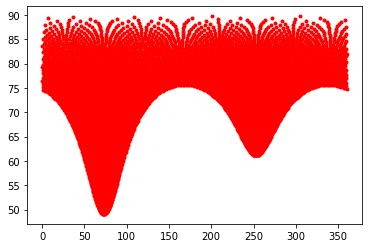

In [54]:
plt.plot(lons[-30:],lats[-30:],'r.');

In [55]:
def deseam(lon, lat, data):
    """
    Function to get rid of the "seam" that shows up on 
    the map when you're using these curvilinear grids.
    """
    i, j = lat.shape
    new_lon = np.zeros((i, j + 1))
    new_lon[:, :-1] = lon
    new_lon[:, -1] = lon[:, 0]

    new_lat = np.zeros((i, j + 1))
    new_lat[:, :-1] = lat
    new_lat[:, -1] = lat[:, 0]

    new_data = np.zeros((i, j + 1))
    new_data[:, :-1] = data
    new_data[:, -1] = data[:, 0]
    new_data = np.ma.array(new_data, mask=np.isnan(new_data))
    return new_lon, new_lat, new_data

In [56]:
lons, lats, newdata = deseam(lons,lats,data[0,:,:])

## Area Weighting
* Loop over all of the ensemble members to create figures

In [59]:
areacello = dset_cccma_areacello['areacello'].squeeze()

In [60]:
member_ids = list_of_members['member_id']

In [61]:
aw_arctic_ice_series = np.zeros((len(dset_cccma_sithick['time']), len(member_ids)))

icount = 0
for i in member_ids:
    my_memberid = "member_id==" + "\'" + str(i) +"\'"
    filenames = list_of_members.query(my_memberid)['zstore'].iloc[0]
    dset_cccma_sithick=xr.open_zarr(fsspec.get_mapper(filenames), consolidated=True)
    
    sithick = dset_cccma_sithick['sithick'].squeeze()
    
    # Grab north of the equator
    arctic_ice = sithick.where(areacello.latitude > 0)
    arctic_ice = sithick.where(sithick > 0)
    
    # compute area-weighted mean
    #aw_arctic_ice = (arctic_ice * areacello).sum(['j', 'i']) / areacello.sum()
    aw_arctic_ice_series[:, icount] = (arctic_ice * areacello).sum(['j', 'i']) / areacello.sum()
    
    icount = icount + 1
    #lines = aw_arctic_ice.groupby('time.year').mean('time')
    #ax1.grid(True)

aw_arctic_ice_series = pd.DataFrame(aw_arctic_ice_series)  

mean_values = aw_arctic_ice_series.mean(axis=0)
variance_values = np.var(aw_arctic_ice_series, axis=0)

In [62]:
datetimeindex = dset_cccma_sithick.indexes['time'].to_datetimeindex()
aw_arctic_ice_series
aw_arctic_ice_series['datetime'] = datetimeindex
aw_arctic_ice_series = aw_arctic_ice_series.set_index(['datetime'])

<ipython-input-62-6c69c3325bbb>:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = dset_cccma_sithick.indexes['time'].to_datetimeindex()


In [63]:
yearly_means = aw_arctic_ice_series.groupby([aw_arctic_ice_series.index.year]).mean('datetime')

### Plotting Means and Variability

Text(0.5, 1.0, 'Area Weighted Sea Ice Thickness')

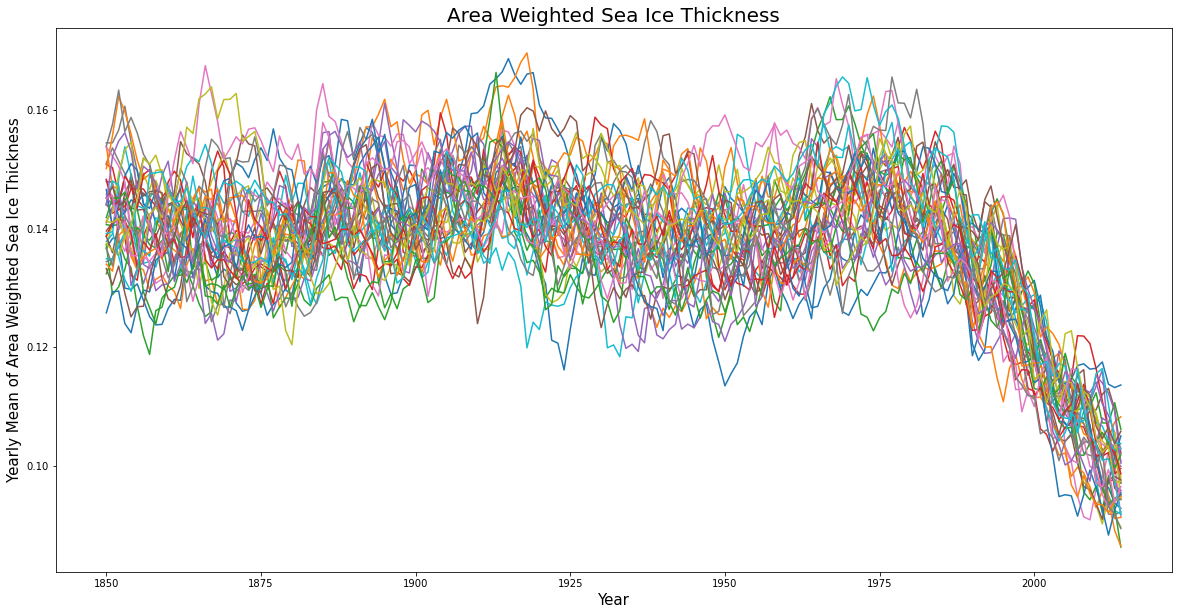

In [64]:
plt.figure(figsize=(20,10))
plt.plot(yearly_means)
plt.xlabel('Year' ,fontsize=15)
plt.ylabel('Yearly Mean of Area Weighted Sea Ice Thickness', fontsize=15)
plt.title('Area Weighted Sea Ice Thickness', fontsize=20)

Text(0.5, 1.0, 'Ensemble Mean for Area Weighted Sea Ice Thickness')

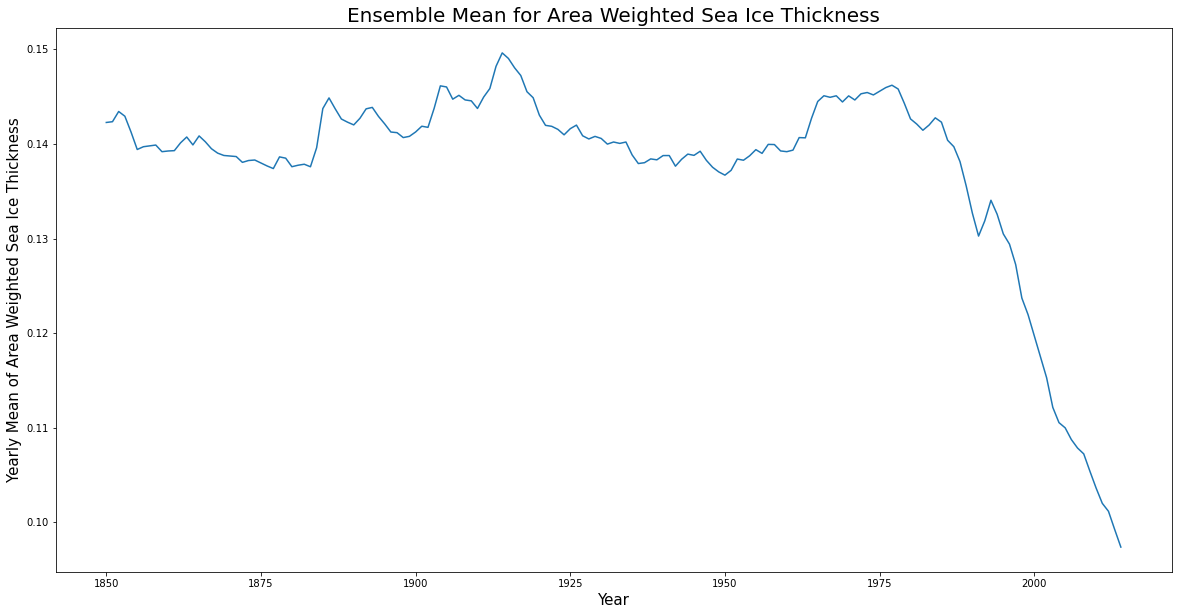

In [65]:
ensemble_mean = yearly_means.mean(axis=1)

plt.figure(figsize=(20,10))
plt.plot(ensemble_mean)
plt.xlabel('Year' ,fontsize=15)
plt.ylabel('Yearly Mean of Area Weighted Sea Ice Thickness', fontsize=15)
plt.title('Ensemble Mean for Area Weighted Sea Ice Thickness', fontsize=20)

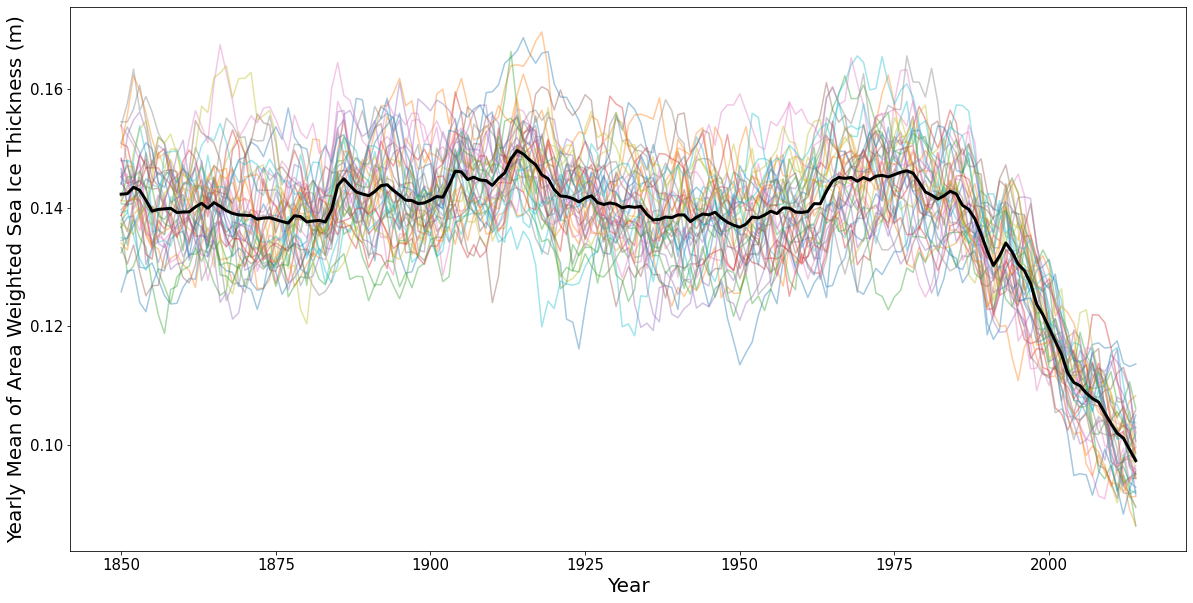

In [66]:
plt.figure(figsize=(20,10))
plt.plot(yearly_means, alpha = 0.4)
plt.plot(ensemble_mean, linewidth = 3, color = 'black')
plt.xlabel('Year' ,fontsize=20)
plt.ylabel('Yearly Mean of Area Weighted Sea Ice Thickness (m)', fontsize=20)
#plt.title('Area Weighted Sea Ice Thickness', fontsize=23)
plt.savefig('cccma_historical_variability_members_large.png')
plt.tick_params(axis='both', which='major', labelsize=15)

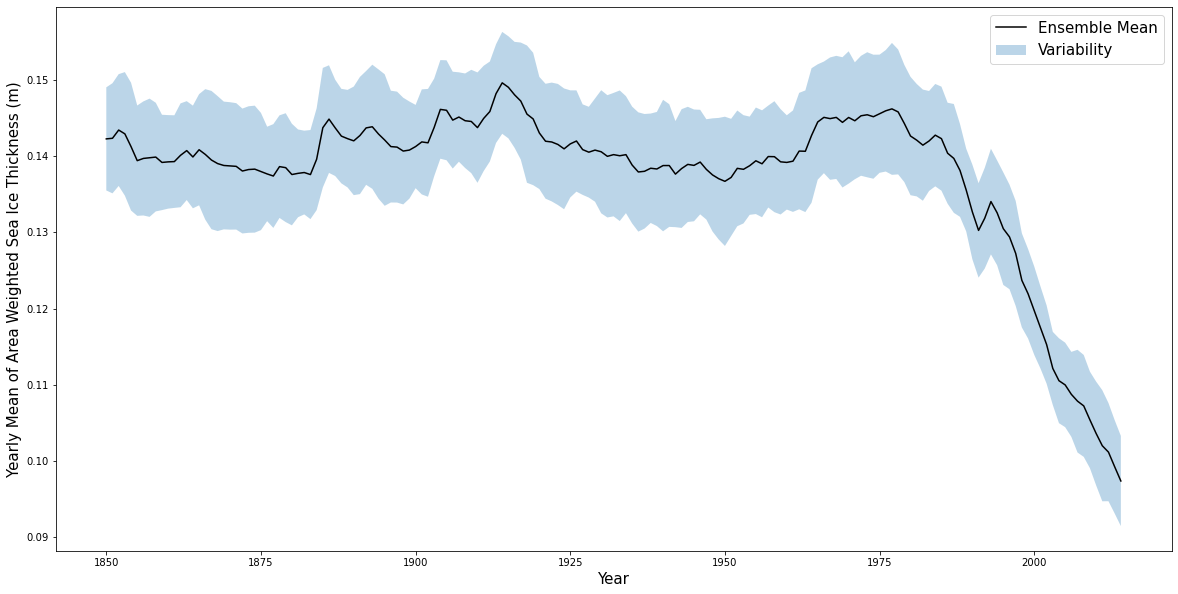

In [67]:
ensemble_std = yearly_means.std(axis=1)
top_bound_std = ensemble_mean + ensemble_std
bottom_bound_std = ensemble_mean - ensemble_std


plt.figure(figsize=(20,10))
plt.plot(ensemble_mean, color = "black")
plt.fill_between(ensemble_std.index, bottom_bound_std, top_bound_std, alpha=0.3)
plt.xlabel('Year' ,fontsize=15)
plt.ylabel('Yearly Mean of Area Weighted Sea Ice Thickness (m)', fontsize=15)
plt.legend(["Ensemble Mean", "Variability"], fontsize = 15)
#plt.title('Ensemble Mean for Area Weighted Sea Ice Thickness', fontsize=20)
plt.savefig('cccma_historical_variability_shaded.png')